<a href="https://colab.research.google.com/github/GabrielArcanjo97/NLP/blob/main/Machine_Larning_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install pyspark

In [70]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[*]')\
        .appName('NLP')\
        .getOrCreate()

spark

In [71]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
dados = spark.read.csv('/content/drive/MyDrive/BIG DATA/NLP - Processamento de Linguagem Natural/imdb-reviews-pt-br.csv',
                       escape="\"", header=True, inferSchema=True)

In [74]:
dados.show(5)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
+---+--------------------+--------------------+---------+
only showing top 5 rows



In [75]:
dados.count()

49459

In [76]:
dados.columns

['id', 'text_en', 'text_pt', 'sentiment']

In [77]:
dados.groupby('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [78]:
dados.filter(dados.id==190).select('text_pt','sentiment').show()

+--------------------+---------+
|             text_pt|sentiment|
+--------------------+---------+
|Este é sem dúvida...|      neg|
+--------------------+---------+



In [79]:
from pyspark.sql import functions as f

In [80]:
dados.select('*').where(f.col('sentiment')!='neg').show()

+-----+--------------------+--------------------+---------+
|   id|             text_en|             text_pt|sentiment|
+-----+--------------------+--------------------+---------+
|12391|I went and saw th...|Eu fui e vi este ...|      pos|
|12392|Actor turned dire...|O diretor do ator...|      pos|
|12393|As a recreational...|Como um jogador d...|      pos|
|12394|I saw this film i...|Eu vi esse filme ...|      pos|
|12395|Bill Paxton has t...|Bill Paxton levou...|      pos|
|12396|I saw this film o...|Eu vi esse filme ...|      pos|
|12397|Maybe Im reading ...|Talvez eu esteja ...|      pos|
|12398|I felt this film ...|Eu senti que esse...|      pos|
|12399|This movie is ama...|Este filme é incr...|      pos|
|12400|I loved this movi...|Eu amei esse film...|      pos|
|12401|I was fortunate t...|Tive a sorte de a...|      pos|
|12402|I first saw this ...|Eu vi esse filme ...|      pos|
|12403|I must say, every...|Devo dizer que, t...|      pos|
|12404|My wife is a ment...|Minha esposa

In [81]:
dados.filter(dados.id==12408).select('text_pt','sentiment').show()

+--------------------+---------+
|             text_pt|sentiment|
+--------------------+---------+
|Fiquei surpreso c...|      pos|
+--------------------+---------+



**WordCloud - Utilizado para visualizar palavras que mais se repetem no texto**

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [83]:
amostra = dados.select('text_pt').sample(0.1, seed=101)

In [84]:
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [85]:
wordcloud = WordCloud(
    background_color='white',
    width=1000,
    height=600,
    prefer_horizontal=True,
    collocations=False
).generate(str(tudo))

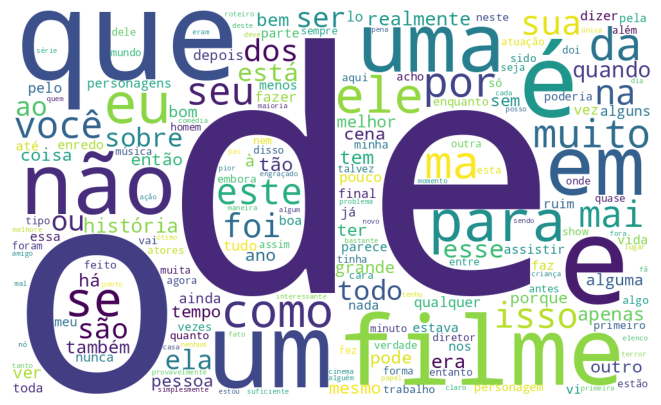

In [87]:
plt.figure(figsize=(18,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Retirando caracteres especiais ou que não tem relevancia**

In [88]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
dados = dados.withColumn('texto_regex', f.regexp_replace('text_en',"[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]",""))

In [93]:
dados.show(5)

+---+--------------------+--------------------+---------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|
+---+--------------------+--------------------+---------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



**Retirando espaçamentos do inicio e final dos textos**

In [94]:
dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))

In [96]:
dados.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



**Tokenizando - Serve para repartir textos grandes em pequenas partes**

In [97]:
from pyspark.ml.feature import Tokenizer

In [98]:
tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')

In [99]:
tokenizado = tokenizer.transform(dados)

In [101]:
tokenizado.select('texto_limpo','tokens').show(5)

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
+--------------------+--------------------+
only showing top 5 rows



**Contando quantos tokens foram gerados para cada linha**

In [102]:
from pyspark.sql.types import IntegerType

In [103]:
countTokens = f.udf(lambda tokens:len(tokens), IntegerType())

In [107]:
tokenizado.select('texto_limpo','tokens').withColumn('freq_tokens', countTokens(f.col('tokens'))).show(5)

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
+--------------------+--------------------+-----------+
only showing top 5 rows



**StopWord - Utilizando para reduzir o tamanho do texto, removendo palavras que não tem peso no texto, como "o", "a", "e", "para", "por", etc**

Pode ser utilizado de duas formas, StopWordsRemover() nativo do spark, ou o stopwords() da biblioteca nltk do Python.

In [109]:
data = [(1,'Spark é ótimo e NLP com Spark é fácil'),
         (0,'Spark MLlib não ajuda muito'),
         (1,'O MLlib do Spark ajuda e é fácil')]

colName = ['label','texto_limpo']
df = spark.createDataFrame(data, colName)

In [110]:
df.show()

+-----+--------------------+
|label|         texto_limpo|
+-----+--------------------+
|    1|Spark é ótimo e N...|
|    0|Spark MLlib não a...|
|    1|O MLlib do Spark ...|
+-----+--------------------+



In [112]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
stop_A = stopwords.words('portuguese')

In [114]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords('portuguese')

In [115]:
from pyspark.ml.feature import Tokenizer

In [116]:
tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
tokenized = tokenizer.transform(df)

In [117]:
remover = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords= stop_A)
df = remover.transform(tokenized)

In [118]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [122]:
remover = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords= stop_B)
df = remover.transform(tokenized)

In [123]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [ ]:
# Usando a base de dados

In [124]:
remover = StopWordsRemover(inputCol='tokens', outputCol='texto_final')
feature_data = remover.transform(tokenizado)

In [126]:
feature_data.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [128]:
feature_data.select('tokens','texto_final')\
    .withColumn('freq_tokens', countTokens(f.col('tokens')))\
    .withColumn('freq_tokens_limpo', countTokens(f.col('texto_final'))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|freq_tokens|freq_tokens_limpo|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

**Bag of Words - é uma lista que contem todas as palavras que estão nos textos de maneira não repetida e tem papel importante para identificar as palavras mais recorrentes e entender se elas agregam algum sentido.**

In [129]:
from pyspark.ml.feature import CountVectorizer

In [130]:
cv = CountVectorizer(inputCol='texto_final', outputCol='CountVec')

In [131]:
model = cv.fit(feature_data)

In [146]:
# Selecionando somente as 20 primeiras palavras

model.vocabulary[:20]

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'first',
 'dont']

In [132]:
CountVector_feature = model.transform(feature_data)

In [135]:
CountVector_feature.select('texto_final','CountVec').show(5)

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+
only showing top 5 rows



**Hashing TF - É gerado a mesma estrutura do bag of words, entretando aqui limitamos o número de palavras contabilizadas.**

Ideal para diminuindo a sobrecarga computacional

In [147]:
from pyspark.ml.feature import HashingTF

In [148]:
HTF = HashingTF(inputCol='texto_final',outputCol='hashing_TF')
HTF.setNumFeatures(50)

HashingTF_86c6d6a97241

In [150]:
HTFfeature = HTF.transform(CountVector_feature)

In [151]:
HTFfeature.select('texto_final','hashing_TF').show(5)

+--------------------+--------------------+
|         texto_final|          hashing_TF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+
only showing top 5 rows



**TF-IDF - é uma medida estatística que visa indicar a importância de uma palavra em relação ao conjunto. É frequentemente utilizado como fator de ponderação na recuperação de informações e na mineração de dados. Em suma, este processo atribuirá um peso para cada uma das palavras.**

In [152]:
from pyspark.ml.feature import IDF

In [154]:
idf = IDF(inputCol='hashing_TF', outputCol='features')

In [155]:
model = idf.fit(HTFfeature)

In [156]:
TFIDFfeature = model.transform(HTFfeature)

In [159]:
TFIDFfeature.select('hashing_TF','features').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Codificando variavel resposta - "sentiment"**

In [160]:
TFIDFfeature.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [161]:
from pyspark.ml.feature import StringIndexer

In [162]:
stringindexer = StringIndexer(inputCol='sentiment', outputCol='label')

In [163]:
dados = stringindexer.fit(dados).transform(dados)

In [165]:
dados.groupby(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



**Pipeline - A função pipeline() executa tarefas específicas que contribui para um objetivo maior, além de entregar um código mais replicável e profissional.**

In [166]:
from pyspark.ml import Pipeline

In [172]:
# vai gerar os tokens da base de dados

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')

In [173]:
# removendo as palavras corretivas, preposição.

stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final')

In [174]:
# vai contabilizar as palavras

hashingTF = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000)

In [175]:
# ponderando as palavras

tfidf = IDF(inputCol='HTF', outputCol='features')

In [176]:
# escolhe a ordem a ser executada

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf])

In [177]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [178]:
dados_transformados.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

**Treinando o Modelo**

**Modelo de Clasificação - Árvore de Decisão**

In [179]:
featureDF = dados_transformados.select(['features','label'])

In [181]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [180]:
featureDF.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [206]:
# Pipeline de transformação e ajuste

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final')
hashingTF = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000)
tfidf = IDF(inputCol='HTF', outputCol='features')

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf, dt])

In [207]:
treino, teste = dados.randomSplit([0.7,0.3], seed=101)

In [208]:
dt_model = pipeline.fit(treino)

In [209]:
predictions = dt_model.transform(teste)

In [210]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [366.0,1112.0]|[0.24763193504736...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

In [211]:
predictions.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [212]:
tp = predictions.select('label','prediction').where((f.col('label')==1)&(f.col('prediction')==1)).count()
tn = predictions.select('label','prediction').where((f.col('label')==0)&(f.col('prediction')==0)).count()
fp = predictions.select('label','prediction').where((f.col('label')==1)&(f.col('prediction')==0)).count()
fn = predictions.select('label','prediction').where((f.col('label')==0)&(f.col('prediction')==1)).count()

print(tp, tn, fp, fn)

5208 4722 2099 2791


In [213]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [214]:
evaluator = MulticlassClassificationEvaluator()

In [215]:
print('Acurácia: %f'% evaluator.evaluate(predictions, {evaluator.metricName:'accuracy'}))
print('Precisão: %f'% evaluator.evaluate(predictions, {evaluator.metricName:'precisionByLabel', evaluator.metricLabel:1}))
print('Recall: %f'% evaluator.evaluate(predictions, {evaluator.metricName:'recallByLabel', evaluator.metricLabel:1}))
print('F1: %f'% evaluator.evaluate(predictions, {evaluator.metricName:'fMeasureByLabel', evaluator.metricLabel:1}))

Acurácia: 0.670040
Precisão: 0.651081
Recall: 0.712741
F1: 0.680517
